## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on Fashion MNIST data, a classification task.

The model follows: https://www.kaggle.com/code/m0hand/fashion-mnist-cnn

In [58]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.losses import MSE, CategoricalCrossentropy
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from utils import GradientRelativeEntropy

tf.random.set_seed(42)

## The MNIST Data

In [2]:
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.convert_to_tensor(x_train / 255.0, 'float32')
x_test = tf.convert_to_tensor(x_test / 255.0, 'float32')
y_train = tf.one_hot(y_train, 10, dtype='float32')
y_test = tf.one_hot(y_test, 10, dtype='float32')

x_train.shape, y_train.shape

(TensorShape([60000, 28, 28]), TensorShape([60000, 10]))

## Train a Model with Gradient Loss

In [3]:
model = Sequential([ 
    Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, 'relu'),
    Dense(10, 'softmax')
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [4]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss, *_ = gradient_loss_fn(x, y)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss

In [5]:
def evaluate(model):
    return accuracy_score(
        tf.argmax(y_test, axis=1),
        tf.argmax(model(x_test), axis=1),
    )

In [6]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds = ds.batch(100)

In [7]:
for epoch in range(20):
    for x, y in tqdm(ds):
        loss = train_step(x, y)
    print(epoch, loss.numpy(), evaluate(model))

100%|██████████████████████████████████████████████████████████| 600/600 [00:56<00:00, 10.69it/s]
2024-03-21 14:25:35.518449: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1730560000 exceeds 10% of free system memory.
2024-03-21 14:25:35.963048: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1730560000 exceeds 10% of free system memory.
2024-03-21 14:25:36.478747: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1730560000 exceeds 10% of free system memory.
2024-03-21 14:25:36.912818: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 432640000 exceeds 10% of free system memory.


0 0.017590532 0.8261


100%|██████████████████████████████████████████████████████████| 600/600 [00:54<00:00, 10.96it/s]
2024-03-21 14:26:32.421456: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1730560000 exceeds 10% of free system memory.


1 0.016829625 0.8502


100%|██████████████████████████████████████████████████████████| 600/600 [01:05<00:00,  9.14it/s]


2 0.017404225 0.8497


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.04it/s]


3 0.01662075 0.8648


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.06it/s]


4 0.016316539 0.8704


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  8.98it/s]


5 0.016391957 0.8705


100%|██████████████████████████████████████████████████████████| 600/600 [01:07<00:00,  8.95it/s]


6 0.01598248 0.8833


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.03it/s]


7 0.01573523 0.8851


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.09it/s]


8 0.015754428 0.8863


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.01it/s]


9 0.016180752 0.8885


100%|██████████████████████████████████████████████████████████| 600/600 [01:05<00:00,  9.16it/s]


10 0.015613159 0.89


100%|██████████████████████████████████████████████████████████| 600/600 [01:05<00:00,  9.16it/s]


11 0.015405157 0.8936


100%|██████████████████████████████████████████████████████████| 600/600 [01:03<00:00,  9.48it/s]


12 0.015536223 0.8959


100%|██████████████████████████████████████████████████████████| 600/600 [00:55<00:00, 10.71it/s]


13 0.015510559 0.898


100%|██████████████████████████████████████████████████████████| 600/600 [00:58<00:00, 10.34it/s]


14 0.015406152 0.8967


100%|██████████████████████████████████████████████████████████| 600/600 [00:58<00:00, 10.26it/s]


15 0.015751446 0.8956


100%|██████████████████████████████████████████████████████████| 600/600 [00:57<00:00, 10.40it/s]


16 0.015495152 0.8982


100%|██████████████████████████████████████████████████████████| 600/600 [00:57<00:00, 10.51it/s]


17 0.015629498 0.8945


100%|██████████████████████████████████████████████████████████| 600/600 [01:03<00:00,  9.44it/s]


18 0.015373444 0.8951


100%|██████████████████████████████████████████████████████████| 600/600 [01:06<00:00,  9.03it/s]


19 0.015497571 0.8955


In [8]:
evaluate(model)

0.8955

## Baseline Model with Usual Loss

In [9]:
baseline_model = Sequential([ 
    Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, 'relu'),
    Dense(10, 'softmax')
])

In [10]:
baseline_model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [11]:
baseline_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/20
1875/1875 - 31s - loss: 0.4600 - accuracy: 0.8345 - val_loss: 0.3484 - val_accuracy: 0.8784 - 31s/epoch - 16ms/step
Epoch 2/20
1875/1875 - 30s - loss: 0.3084 - accuracy: 0.8881 - val_loss: 0.3678 - val_accuracy: 0.8674 - 30s/epoch - 16ms/step
Epoch 3/20
1875/1875 - 30s - loss: 0.2665 - accuracy: 0.9017 - val_loss: 0.2989 - val_accuracy: 0.8884 - 30s/epoch - 16ms/step
Epoch 4/20
1875/1875 - 30s - loss: 0.2348 - accuracy: 0.9133 - val_loss: 0.2749 - val_accuracy: 0.9027 - 30s/epoch - 16ms/step
Epoch 5/20
1875/1875 - 30s - loss: 0.2103 - accuracy: 0.9231 - val_loss: 0.2737 - val_accuracy: 0.9015 - 30s/epoch - 16ms/step
Epoch 6/20
1875/1875 - 31s - loss: 0.1895 - accuracy: 0.9297 - val_loss: 0.2913 - val_accuracy: 0.8947 - 31s/epoch - 16ms/step
Epoch 7/20
1875/1875 - 29s - loss: 0.1712 - accuracy: 0.9357 - val_loss: 0.2658 - val_accuracy: 0.9053 - 29s/epoch - 15ms/step
Epoch 8/20
1875/1875 - 29s - loss: 0.1531 - accuracy: 0.9440 - val_loss: 0.2741 - val_accuracy: 0.9083 - 29s/ep

In [12]:
evaluate(baseline_model)

0.9052

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [55]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.2, 20)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.normal(tf.shape(x_test)) * stddev
    model_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|████████████████████████████████████████████████████████████| 20/20 [01:27<00:00,  4.40s/it]


Or, non-Gaussian "pixal-flipping" noise.

In [56]:
# flip_ratios, model_accs, baseline_accs = [], [], []
# for flip_ratio in tqdm(np.linspace(0, 0.1, 20)):
#     flip_ratios.append(flip_ratio)
#     x_test_noised = tf.where(tf.random.uniform(tf.shape(x_test)) < flip_ratio, 1 - x_test, x_test)
#     model_accs.append(
#         accuracy_score(tf.argmax(y_test, axis=1),
#                        tf.argmax(model(x_test_noised), axis=1))
#     )
#     baseline_accs.append(
#         accuracy_score(tf.argmax(y_test, axis=1),
#                        tf.argmax(baseline_model(x_test_noised), axis=1))
#     )

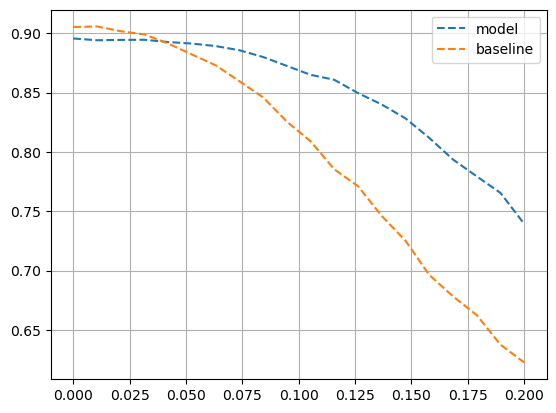

In [59]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## Conclusion

- By simply using the "gradient loss", we obtained a result that approaches the baseline. But the robustness is greatly out-performs the baseline.
- Because the "gradient loss" computes gradients twice (once by x and y, and once by model variables), the training duration is doubled.
- We also tested non-Gaussian noise, such as flipping the given ratio of pixals. The result is that the model trained by the "gradient loss" is no more robust, but no less, than the baseline model. The difference is that the pixal-flipping noise is not continuous. The noised images jump to other local minima of the loss function.